In [46]:
import pandas as pd
import yaml
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from modeling import update_config

In [47]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 'rushing_tds_roll',
 'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll']

In [48]:
team = pd.read_csv('data/agg/team_stats.csv', index_col=0)
opp = pd.read_csv('data/agg/opp_stats.csv', index_col=0)
team_stat_cols = [
 'completions_team_roll',
 'attempts_team_roll',
 'carries_team_roll',
 'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'completions_opp_roll',
 'attempts_opp_roll',
 'carries_opp_roll',
 'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll']

In [49]:
pbp = pd.read_parquet("data/pbp.parquet")
pbp = pbp.merge(team, left_on=['posteam','season','week'], right_on=['recent_team','season','week']).drop('recent_team',axis=1)
pbp = pbp.merge(opp, left_on=['defteam','season','week'], right_on=['opponent_team','season','week']).drop('opponent_team',axis=1)

rushes = pbp.loc[(pbp.play_type=='run') & (~pbp.yards_gained.isna())].copy(
    deep=True
)


In [50]:
rusher_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')[['season', 'team_name', 'week', 'game_type',  'gsis_id', 
       'position', 'depth_position', 'full_name', 'dense_depth',
 'carries_roll',
 'rushing_yards_roll',
 'rushing_tds_roll',
 'rushing_first_downs_roll',
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'fantasy_points_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll']]
rushes = rushes.merge(
    rusher_stats,
    left_on=["posteam", "season", "week", "rusher_player_id"],
    right_on=["team_name", "season", "week", 'gsis_id'],
)
rushes[[ 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll', 'yards_per_carry_roll', 'rushing_tds_roll','rushing_first_downs_roll']] = rushes[[ 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll','rushing_tds_roll','rushing_first_downs_roll']].fillna(0)

rushes = rushes.loc[~rushes.down.isna()].copy(deep=True)

In [51]:
game_context_cols = [
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    "posteam_score",
    "defteam_score",
    "score_differential",
    'quarter_seconds_remaining',
    'half_seconds_remaining',
    'game_seconds_remaining',
    "wind",
    "temp",
    'spread_line',
    'total_line'
]
team_rush_cols = [
 'rushing_yards_team_roll',
 'rushing_yards_opp_roll']

In [52]:
rush_yards_cols = game_context_cols + rusher_stat_cols + team_rush_cols

In [53]:
rushes['yards_shifted'] = rushes['yards_gained'] + 30

In [54]:
rushes[rush_yards_cols].isna().sum()

yardline_100                 0
down                         0
goal_to_go                   0
ydstogo                      0
posteam_score                0
defteam_score                0
score_differential           0
quarter_seconds_remaining    0
half_seconds_remaining       0
game_seconds_remaining       0
wind                         0
temp                         0
spread_line                  0
total_line                   0
carries_roll                 0
rushing_yards_roll           0
rushing_tds_roll             0
rushing_first_downs_roll     0
fantasy_points_ppr_roll      0
yards_per_carry_roll         0
rushing_yards_team_roll      0
rushing_yards_opp_roll       0
dtype: int64

In [55]:
X = torch.Tensor((rushes[rush_yards_cols].values))
y = torch.tensor(rushes['yards_shifted'].astype(int).values, dtype=torch.long)
obs = len(X)
num_feats = len(rush_yards_cols)


In [56]:
class WithDropout(nn.Module):
    def __init__(self, n_in=11, n_out=109, n_hidden=50, dropout_prob=0.):
        super(WithDropout, self).__init__()
        self.main_layers = nn.Sequential(
        nn.Linear(n_in, n_hidden),nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),nn.ReLU(),
        nn.Dropout(p=dropout_prob),
        nn.Linear(n_hidden, n_hidden),nn.ReLU(),
        )
        self.add_yardline = nn.Linear(n_hidden + 1, n_out)
    def forward(self, x):
        # Extract the feature to pass to the final layer (e.g., the first feature)
        feature_to_pass = x[:, 0].unsqueeze(1)  # Assuming you want the first feature, shape [batch_size, 1]
        
        x = self.main_layers(x)
        x = torch.cat((x, feature_to_pass), dim=1) 
        x = self.add_yardline(x)
        
        return x

In [57]:

def train_model(X, y, n_in, n_out,n_hidden=50, epochs=20, batch_size=512):
    # Define the model, loss function, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = WithDropout(n_in, n_out, n_hidden=n_hidden).to(device)
    criterion = nn.CrossEntropyLoss()  # Suitable for classification
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)

    num_samples = X.size(0)
    indices = torch.randperm(num_samples, device=X.device)

    # Calculate train-test split sizes
    split = num_samples // 5  # 20% test data
    test_indices = indices[:split]
    train_indices = indices[split:]

    # Create train-test splits using the shuffled indices
    train_X, test_X = X[train_indices].to(device), X[test_indices].to(device)
    train_y, test_y = y[train_indices].to(device), y[test_indices].to(device)

    # Training loop
    epochs = epochs
    batch_size = 512

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(train_X.size(0))
        epoch_loss = 0

        for i in range(0, train_X.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_X, batch_y = train_X[indices], train_y[indices]

            optimizer.zero_grad()
            outputs = model(batch_X)  # Shape: [batch_size, 100]
            loss = criterion(outputs, batch_y)  # batch_y must be [batch_size] with class indices
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_X):.4f}")

        # Evaluation on the test set
    model.eval()
    with torch.no_grad():
        test_preds = model(test_X)  # Shape: [num_samples, 100]
        test_loss = criterion(test_preds, test_y).item() 
        accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    test_preds = F.softmax(test_preds,dim=1)[0].to('cpu')
    samples = torch.clamp( torch.multinomial(test_preds,100,replacement=True),max=76) - 30
    avg = round(samples.double().mean().item(), 3)
    plt.hist(test_preds, alpha=0.5, color='r')
    plt.hist(test_y.to('cpu'), alpha=0.5, color='b')
    return model

Epoch 1/10, Loss: 0.0158
Epoch 2/10, Loss: 0.0057
Epoch 3/10, Loss: 0.0057
Epoch 4/10, Loss: 0.0057
Epoch 5/10, Loss: 0.0057
Epoch 6/10, Loss: 0.0057
Epoch 7/10, Loss: 0.0057
Epoch 8/10, Loss: 0.0057
Epoch 9/10, Loss: 0.0057
Epoch 10/10, Loss: 0.0057
Test Loss: 2.9098, Test Accuracy: 0.1174


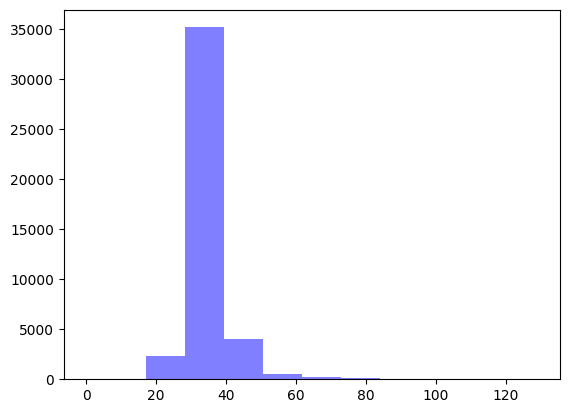

In [58]:
rush_yards_model = train_model(X,y, 22, 130, n_hidden = 1000, epochs=10) # 2.90, 

In [59]:
rush_yards_model = rush_yards_model.to('cpu')

In [60]:
model_path = "models/run_yards_gained.pt"
torch.save(rush_yards_model.state_dict(), model_path)


feature_config = {
    'rush_yard_cols':rush_yards_cols
}
feature_config

update_config(feature_config)

In [61]:
test = rushes.loc[rushes.yardline_100==5][rush_yards_cols+ ['yards_shifted']]
test

,yardline_100,down,goal_to_go,ydstogo,posteam_score,defteam_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,...,total_line,carries_roll,rushing_yards_roll,rushing_tds_roll,rushing_first_downs_roll,fantasy_points_ppr_roll,yards_per_carry_roll,rushing_yards_team_roll,rushing_yards_opp_roll,yards_shifted
166,5.0,3.0,0,4.0,0.0,0.0,0.0,269.0,1169.0,2969.0,...,40.5,0.000000,0.000000,0.000000,0.000000,0.000000,3.875000,89.000000,89.000000,32.0
307,5.0,2.0,0,4.0,17.0,14.0,3.0,190.0,190.0,190.0,...,37.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.409091,119.000000,119.000000,33.0
416,5.0,2.0,1,5.0,0.0,0.0,0.0,632.0,1532.0,3332.0,...,44.5,0.000000,0.000000,0.000000,0.000000,0.000000,4.400000,101.000000,101.000000,34.0
740,5.0,2.0,1,5.0,0.0,0.0,0.0,160.0,1060.0,2860.0,...,45.5,0.000000,0.000000,0.000000,0.000000,0.000000,3.947368,109.000000,109.000000,32.0
1013,5.0,2.0,0,4.0,7.0,10.0,-3.0,614.0,614.0,2414.0,...,41.0,8.000000,39.000000,0.000000,5.000000,6.000000,2.818182,69.500000,28.000000,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211900,5.0,2.0,0,4.0,9.0,20.0,-11.0,526.0,1426.0,1426.0,...,43.0,18.797095,92.528914,0.860030,4.297644,17.910145,3.625000,107.285714,77.428571,33.0
212118,5.0,1.0,1,5.0,10.0,6.0,4.0,827.0,827.0,827.0,...,36.5,13.594059,71.648165,0.044582,3.472685,10.124248,2.950000,69.571429,92.285714,33.0
212124,5.0,1.0,1,5.0,6.0,18.0,-12.0,509.0,509.0,509.0,...,36.5,2.380535,9.888008,0.000144,0.303999,1.948298,-2.000000,139.000000,104.142857,28.0
212154,5.0,2.0,0,2.0,10.0,0.0,10.0,435.0,435.0,2235.0,...,44.5,17.274053,84.816442,0.653772,4.136453,18.553421,4.076923,138.571429,95.000000,34.0


<Axes: >

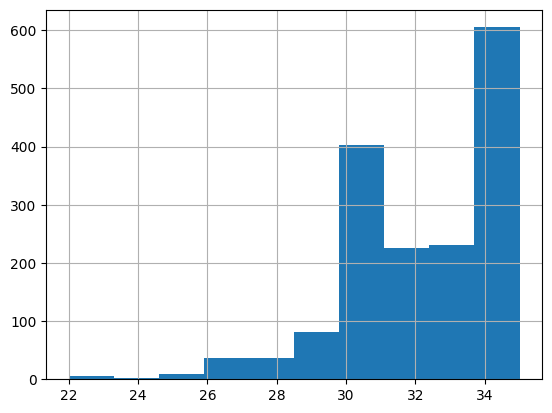

In [62]:
test['yards_shifted'].hist()

torch.Size([1, 22])
torch.Size([130])
torch.Size([1, 22])
torch.Size([130])
torch.Size([1, 22])
torch.Size([130])
torch.Size([1, 22])
torch.Size([130])
torch.Size([1, 22])
torch.Size([130])


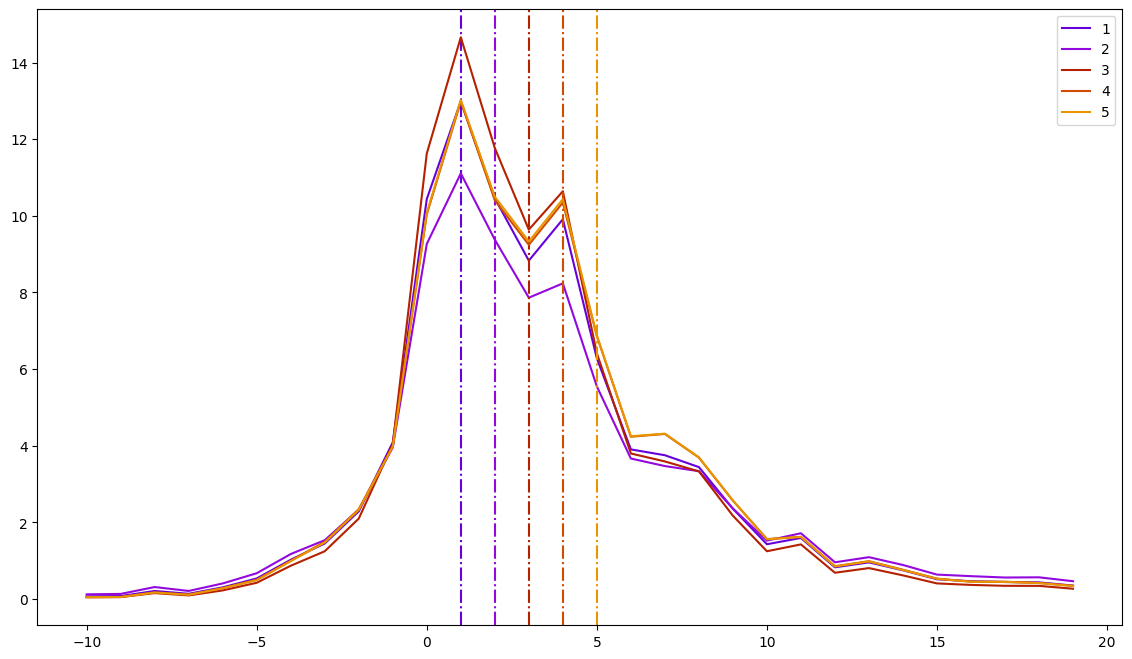

In [63]:
colormap = cm.gnuplot
plt.figure(figsize=(14, 8))
num_yardlines = 6
for yardline in range(1,num_yardlines):

    color = colormap(yardline / num_yardlines) 
    down=1
    test = rushes.loc[rushes.yardline_100==yardline]
    xx = torch.Tensor(test[rush_yards_cols].sample(1).values)
    print(xx.shape)
    with torch.no_grad():
        xy = rush_yards_model(xx)
        xy = (100 * F.softmax(xy,dim=1))[0]
        print(xy.shape)
        x_range = range(-10,20)
    plt.axvline(yardline, color=color, linestyle='-.')
    plt.plot(x_range, xy[20:50], label=yardline, color=color)

plt.legend()

In [64]:
test = rushes.loc[rushes.yardline_100==45].sample(1)
xx = torch.Tensor(test[rush_yards_cols].values)
xy = xy = torch.Tensor(test['yards_shifted'].values)

5.505


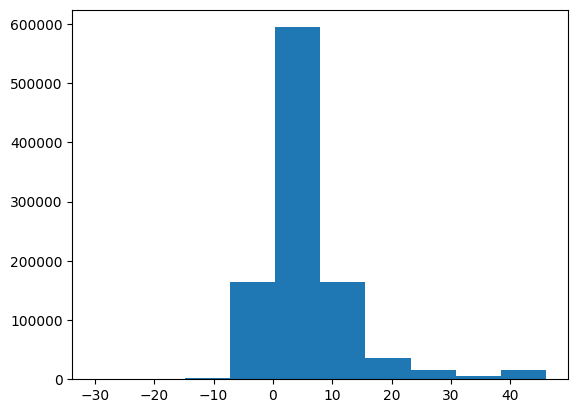

In [65]:
res = rush_yards_model(xx)
res = F.softmax(res,dim=1)[0]
samples = torch.clamp( torch.multinomial(res,1000000,replacement=True),max=76) - 30
avg = round(samples.double().mean().item(), 3)
plt.hist(samples)
print(avg)

In [66]:
[print(a,b) for a,b in zip(list(xx[0]), rush_yards_cols)]
xy

tensor(45.) yardline_100
tensor(3.) down
tensor(0.) goal_to_go
tensor(1.) ydstogo
tensor(14.) posteam_score
tensor(14.) defteam_score
tensor(0.) score_differential
tensor(41.) quarter_seconds_remaining
tensor(41.) half_seconds_remaining
tensor(1841.) game_seconds_remaining
tensor(5.) wind
tensor(58.) temp
tensor(-1.) spread_line
tensor(36.) total_line
tensor(0.) carries_roll
tensor(0.) rushing_yards_roll
tensor(0.) rushing_tds_roll
tensor(0.) rushing_first_downs_roll
tensor(0.5600) fantasy_points_ppr_roll
tensor(1.) yards_per_carry_roll
tensor(89.2857) rushing_yards_team_roll
tensor(97.7143) rushing_yards_opp_roll


tensor([31.])

In [67]:
xx[0][12] #127

tensor(-1.)

spread: -15 5.547
spread: -13 5.558
spread: -11 5.544
spread: -9 5.556
spread: -7 5.555
spread: -5 5.569
spread: -3 5.558
spread: -1 5.559
spread: 1 5.559
spread: 3 5.564
spread: 5 5.546
spread: 7 5.561
spread: 9 5.543
spread: 11 5.553
spread: 13 5.551


(array([   940.,    877.,   3537., 254879., 583227.,  96125.,  29667.,
         12077.,   5265.,  13406.]),
 array([ 0.,  8., 16., 24., 32., 40., 48., 56., 64., 72., 80.]),
 <BarContainer object of 10 artists>)

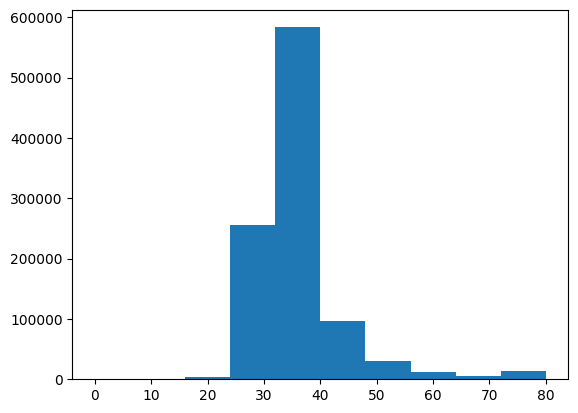

In [68]:
for ypc in range(-15, 15, 2):
    xx[0][12] = torch.tensor(5)
    res = rush_yards_model(xx)
    res = F.softmax(res,dim=1)[0]
    samples = torch.clamp( torch.multinomial(res,1000000,replacement=True),max=80)
    avg = round(samples.double().mean().item()-30, 3)
    print(f'spread: {ypc}',avg) # 3.34
plt.hist(samples)

In [69]:
samples.double().min()

tensor(0., dtype=torch.float64)

<Axes: >

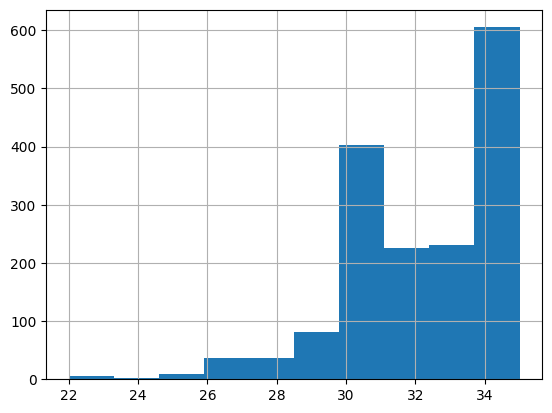

In [70]:
rushes.loc[rushes.yardline_100==5]['yards_shifted'].hist()

In [71]:
passes = pbp.loc[
        (pbp['pass']==1) & 
    (pbp.pass_attempt==1) & 
    (pbp.air_yards >= -20)
    & (pbp.play_type=='pass')
].copy(deep=True).dropna(axis=1,how='all')

In [72]:
receiver_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')[[
    "season",
    "team_name",
    "week",
    "game_type",
    "gsis_id",
    "position",
    "depth_position",
    "full_name",
    "dense_depth",
    "receptions_roll",
    "targets_roll",
    "receiving_yards_roll",
    "receiving_tds_roll",
    "receiving_air_yards_roll",
    "receiving_yards_after_catch_roll",
    "receiving_first_downs_roll",
    "target_share_roll",
    "air_yards_share_roll",
    "fantasy_points_ppr_roll",
    'yards_per_target_roll',
    'yards_per_catch_roll',
]]

In [73]:
passes = passes.merge(
    receiver_stats,
    left_on=["posteam", "season", "week", "receiver_player_id"],
    right_on=["team_name", "season", "week", "gsis_id"],
)
passes


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,receiving_yards_roll,receiving_tds_roll,receiving_air_yards_roll,receiving_yards_after_catch_roll,receiving_first_downs_roll,target_share_roll,air_yards_share_roll,fantasy_points_ppr_roll,yards_per_target_roll,yards_per_catch_roll
0,58.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,103.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,132.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,177.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,254.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,LA,home,ARI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275457,3812.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,38.103053,0.011593,47.612262,14.928183,1.793535,0.171688,0.184008,7.404114,6.947856,10.810116
275458,3869.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,29.855179,0.083781,-1.337273,31.721545,1.191506,0.109480,-0.010025,24.402885,8.692839,15.046364
275459,3894.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,29.855179,0.083781,-1.337273,31.721545,1.191506,0.109480,-0.010025,24.402885,8.692839,15.046364
275460,3953.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,9.210293,0.000000,10.228033,7.625124,0.425586,0.057827,0.035774,2.089030,5.034367,7.885517


In [74]:
passes = passes.loc[~passes.receptions_roll.isna()].copy()
#51456 

In [75]:
team_stat_cols = [
 'completions_team_roll',
 'attempts_team_roll',
 'carries_team_roll',
 'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'completions_opp_roll',
 'attempts_opp_roll',
 'carries_opp_roll',
 'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll']

In [76]:
air_yards_cols = [
    "dense_depth",
    "receptions_roll",
    "targets_roll",
    "receiving_yards_roll",
    "receiving_tds_roll",
    "receiving_air_yards_roll",
    "receiving_yards_after_catch_roll",
    "receiving_first_downs_roll",
    "target_share_roll",
    "air_yards_share_roll",
    "fantasy_points_ppr_roll",
    'yards_per_target_roll',
    'yards_per_catch_roll',
] + game_context_cols + ['passing_yards_opp_roll']

In [77]:
passes['target_share_roll'].isna().sum()

119

In [78]:
passes['air_yards_20'] = passes['air_yards'] + 20
data = passes[air_yards_cols + ['air_yards_20']].copy()
data = data.dropna()
X = torch.Tensor((data[air_yards_cols].values))
y = torch.tensor(data['air_yards_20'].astype(int).values, dtype=torch.long)
obs = len(X)
num_feats = len(air_yards_cols)
y.shape

torch.Size([267818])

Epoch 1/20, Loss: 0.0079
Epoch 2/20, Loss: 0.0068
Epoch 3/20, Loss: 0.0068
Epoch 4/20, Loss: 0.0068
Epoch 5/20, Loss: 0.0068
Epoch 6/20, Loss: 0.0068
Epoch 7/20, Loss: 0.0068
Epoch 8/20, Loss: 0.0068
Epoch 9/20, Loss: 0.0068
Epoch 10/20, Loss: 0.0068
Epoch 11/20, Loss: 0.0068
Epoch 12/20, Loss: 0.0068
Epoch 13/20, Loss: 0.0068
Epoch 14/20, Loss: 0.0068
Epoch 15/20, Loss: 0.0068
Epoch 16/20, Loss: 0.0068
Epoch 17/20, Loss: 0.0068
Epoch 18/20, Loss: 0.0068
Epoch 19/20, Loss: 0.0068
Epoch 20/20, Loss: 0.0068
Test Loss: 3.4504, Test Accuracy: 0.0867


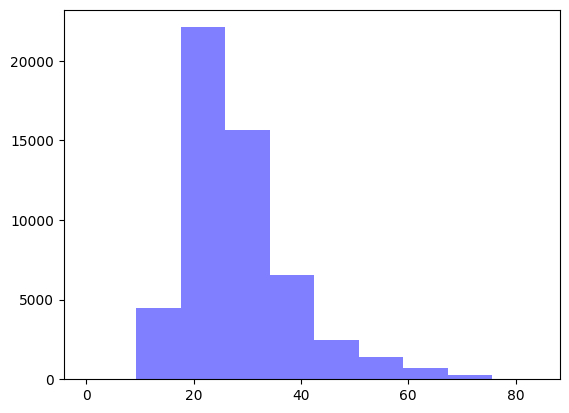

In [79]:
air_yards_model = train_model(X, y, num_feats, 119) # 3.327, 0.0865
air_yards_model = air_yards_model.to('cpu')

In [80]:
model_path = "models/air_yards.pt"
torch.save(air_yards_model.state_dict(), model_path)


feature_config = {
    'air_yards_cols':air_yards_cols,
    'air_yards_model_path': 'models/air_yards.pt',
    'run_yards_model_path': "models/run_yards_gained.pt"
}
feature_config

update_config(feature_config)

11.272468


<Axes: >

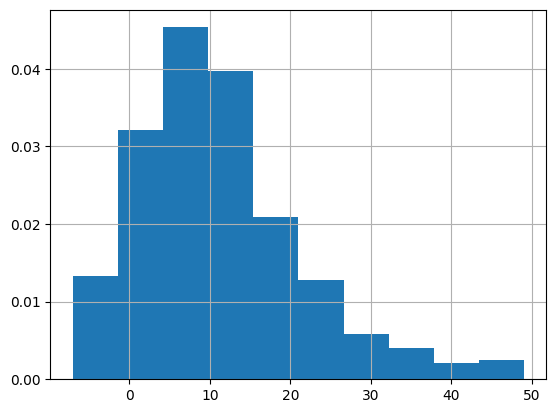

In [81]:
jj = passes.loc[passes.receiver_player_id == '00-0036322']
print(jj['air_yards'].mean())
jj['air_yards'].hist(density=True)


tensor(11.4426, dtype=torch.float64)


(array([0.00017272, 0.00639656, 0.04617591, 0.03132807, 0.00898696,
        0.00394516, 0.00198364, 0.0004293 , 0.00015712, 0.00042455]),
 array([-20., -10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.]),
 <BarContainer object of 10 artists>)

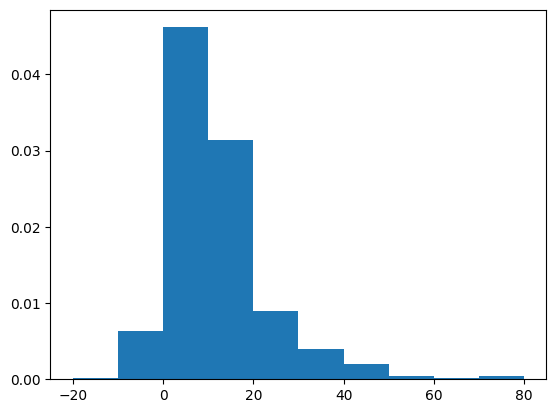

In [82]:
test_x = torch.Tensor(jj[air_yards_cols].values)
res = air_yards_model(test_x)
res = F.softmax(res,dim=1)
samples = torch.clamp( torch.multinomial(res,10000,replacement=True),max=100).reshape(-1) - 20
print(samples.double().mean())
plt.hist(samples,density=True)

In [83]:
passes[['yardline_100','yards_gained','air_yards','yards_after_catch', 'complete_pass']]

,yardline_100,yards_gained,air_yards,yards_after_catch,complete_pass
109,54.0,13.0,9.0,4.0,1.0
116,72.0,23.0,20.0,3.0,1.0
141,74.0,3.0,3.0,0.0,1.0
1086,20.0,0.0,6.0,NaN,0.0
1087,7.0,7.0,3.0,4.0,1.0
...,...,...,...,...,...
275457,49.0,16.0,16.0,0.0,1.0
275458,38.0,7.0,-3.0,10.0,1.0
275459,31.0,20.0,0.0,20.0,1.0
275460,21.0,11.0,-4.0,15.0,1.0


In [84]:
completions = passes.loc[passes.complete_pass==1].copy()
completions['yac_25'] = completions['yards_after_catch'] + 25

In [85]:
yac_cols = air_yards_cols + ['air_yards']
data = completions[yac_cols + ['yac_25']].copy()
data = data.dropna()
X = torch.Tensor((data[yac_cols].values))
y = torch.tensor(data['yac_25'].astype(int).values, dtype=torch.long)
obs = len(X)
air_yards_input = len(yac_cols)
X.shape

torch.Size([173144, 29])

Epoch 1/20, Loss: 0.0072
Epoch 2/20, Loss: 0.0054
Epoch 3/20, Loss: 0.0054
Epoch 4/20, Loss: 0.0054
Epoch 5/20, Loss: 0.0054
Epoch 6/20, Loss: 0.0054
Epoch 7/20, Loss: 0.0054
Epoch 8/20, Loss: 0.0054
Epoch 9/20, Loss: 0.0054
Epoch 10/20, Loss: 0.0054
Epoch 11/20, Loss: 0.0054
Epoch 12/20, Loss: 0.0054
Epoch 13/20, Loss: 0.0054
Epoch 14/20, Loss: 0.0054
Epoch 15/20, Loss: 0.0054
Epoch 16/20, Loss: 0.0054
Epoch 17/20, Loss: 0.0054
Epoch 18/20, Loss: 0.0054
Epoch 19/20, Loss: 0.0054
Epoch 20/20, Loss: 0.0054
Test Loss: 2.7605, Test Accuracy: 0.2382


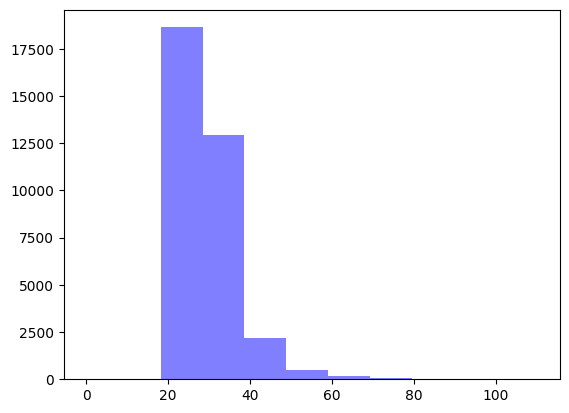

In [86]:
yac_model = train_model(X, y, 29, 125)
yac_model = yac_model.to('cpu')

(array([0.00013818, 0.00011864, 0.00013705, 0.00012932, 0.00028136,
        0.08160432, 0.06875295, 0.04257091, 0.01421545, 0.01932455]),
 array([-25. , -20.6, -16.2, -11.8,  -7.4,  -3. ,   1.4,   5.8,  10.2,
         14.6,  19. ]),
 <BarContainer object of 10 artists>)

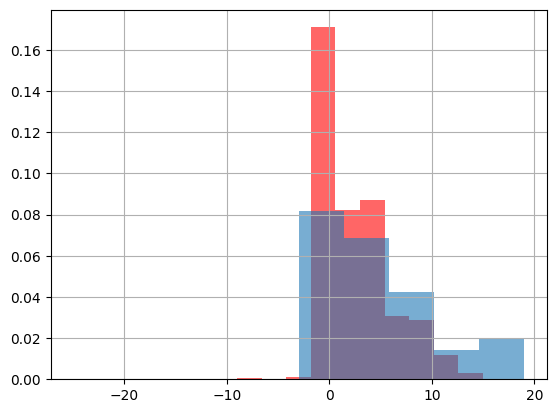

In [87]:
n = 9
ydl = data.loc[data.yardline_100==n]
(ydl['yac_25'] - 25).hist(density=True, alpha=0.6, color='r')
test_x = torch.Tensor(ydl.sample(100)[yac_cols].values)
res = yac_model(test_x)
res = F.softmax(res,dim=1)
samples = torch.clamp(torch.multinomial(res,10000,replacement=True).reshape(-1), max= (n+35)) - 25
plt.hist(samples,density=True, alpha=0.6)

In [88]:
model_path = "models/yac.pt"
torch.save(yac_model.state_dict(), model_path)


feature_config = {
    'yac_cols':yac_cols,
    'yac_path': 'models/yac.pt',
    'run_yards_model_path': "models/run_yards_gained.pt"
}
feature_config

update_config(feature_config)

In [89]:
pbp['desc'].sample(15)

635637    (2:00) (Shotgun) 1-K.Murray pass incomplete de...
491196    (3:42) (Shotgun) 6-J.Luton pass short right to...
392953    (12:15) 22-W.Gallman up the middle to NYG 37 f...
353716    (5:56) (Shotgun) 4-D.Carr pass short right to ...
613400    (10:38) 20-T.Pollard right tackle to NYG 1 for...
226613    (8:44) 26-L.Bell right guard to PIT 26 for -3 ...
78764     (12:06) (Shotgun) 35-L.Ball right guard to DEN...
92651     (:47) (Shotgun) 11-Alex Smith pass incomplete ...
80493     (13:11) (Shotgun) 2-M.Ryan pass short middle t...
372040    (14:07) (No Huddle) 10-E.Manning pass incomple...
69803     (15:00) 35-L.Ball up the middle to DEN 25 for ...
90530     (5:37) (No Huddle) 7-B.Roethlisberger pass inc...
357546    (1:21) (No Huddle, Shotgun) 9-M.Stafford pass ...
98704     (1:47) (Run formation) 28-A.Peterson up the mi...
590753    (4:43) 20-T.Pollard right tackle to MIN 16 for...
Name: desc, dtype: object

In [90]:
pbp.iloc[177294].dropna().to_dict()

{'play_id': 2570.0,
 'game_id': '2013_13_TB_CAR',
 'old_game_id': '2013120100',
 'home_team': 'CAR',
 'away_team': 'TB',
 'season_type': 'REG',
 'week': 13,
 'posteam': 'CAR',
 'posteam_type': 'home',
 'defteam': 'TB',
 'game_date': '2013-12-01',
 'quarter_seconds_remaining': 0.0,
 'half_seconds_remaining': 900.0,
 'game_seconds_remaining': 900.0,
 'game_half': 'Half2',
 'quarter_end': 1.0,
 'drive': 18.0,
 'sp': 0.0,
 'qtr': 3.0,
 'goal_to_go': 0,
 'time': '00:00',
 'yrdln': 'CAR 35',
 'ydstogo': 0.0,
 'ydsnet': 66.0,
 'desc': 'END QUARTER 3',
 'shotgun': 0.0,
 'no_huddle': 0.0,
 'qb_kneel': 0.0,
 'qb_spike': 0.0,
 'qb_scramble': 0.0,
 'home_timeouts_remaining': 3.0,
 'away_timeouts_remaining': 3.0,
 'posteam_timeouts_remaining': 3.0,
 'defteam_timeouts_remaining': 3.0,
 'total_home_score': 24.0,
 'total_away_score': 6.0,
 'posteam_score': 24.0,
 'defteam_score': 6.0,
 'score_differential': 18.0,
 'posteam_score_post': 24.0,
 'defteam_score_post': 6.0,
 'score_differential_post': 18.0